In [2]:
import math
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

In [28]:
np.random.seed(42)

In [29]:
data = pd.read_csv("../Data/DIS.csv", header=None, index_col=None)

In [30]:
data.head(4)

,0,1,2,3,4,5,6
0,1996-12-31,23.011177,23.175543,22.805719,22.928993,17.804647,2719200
1,1997-01-02,22.928993,22.970085,21.942801,22.148258,17.198397,8115400
2,1997-01-03,22.394806,22.805719,22.394806,22.764629,17.677013,4650000
3,1997-01-06,22.764629,22.928993,22.559172,22.682446,17.613201,3623300


In [31]:
all_y = data[5].values
dataset=all_y.reshape(-1, 1)

In [32]:
dataset

array([[ 17.804647],
       [ 17.198397],
       [ 17.677013],
       ...,
       [102.703629],
       [102.959648],
       [102.624855]])

In [33]:
data.shape

(5035, 7)

In [34]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [35]:
# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [36]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [37]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [38]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [39]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
2276/2276 [==============================] - 1s 586us/step - loss: 0.0051
Epoch 2/100
2276/2276 [==============================] - 0s 35us/step - loss: 0.0021
Epoch 3/100
2276/2276 [==============================] - 0s 44us/step - loss: 0.0014
Epoch 4/100
2276/2276 [==============================] - 0s 40us/step - loss: 0.0010
Epoch 5/100
2276/2276 [==============================] - 0s 38us/step - loss: 7.9816e-04
Epoch 6/100
2276/2276 [==============================] - 0s 40us/step - loss: 6.7905e-04
Epoch 7/100
2276/2276 [==============================] - 0s 37us/step - loss: 5.7514e-04
Epoch 8/100
2276/2276 [==============================] - 0s 30us/step - loss: 5.0945e-04
Epoch 9/100
2276/2276 [==============================] - 0s 35us/step - loss: 4.4762e-04
Epoch 10/100
2276/2276 [==============================] - 0s 34us/step - loss: 4.0640e-04
Epoch 11/100
2276/2276 [==============================] - 0s 32us/step - loss: 3.6738e-04
Epoch 12/100
2276/2276 [==========

In [40]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [41]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [42]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.76 RMSE
Test Score: 12.39 RMSE


In [43]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [44]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

testPrices:


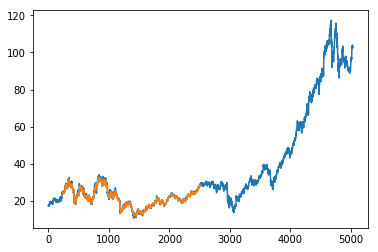

In [45]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

In [46]:
print('testPredictions:')
print(testPredict)

testPredictions:
[[27.53004 ]
 [27.892738]
 [27.818977]
 ...
 [79.40207 ]
 [79.48891 ]
 [79.129654]]


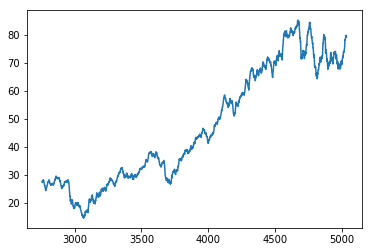

In [47]:
# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.show()